In [87]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
import pymaster as nmt
%matplotlib inline
#import packages

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [88]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128

npix = hp.nside2npix(nside)

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0]) #,  545.0,  857.0
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [89]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined

print(maps_pl.shape)

(7, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [90]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
almsize=hp.Alm.getsize(lmax)
print(almsize)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freqs, almsize), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values

for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    

73920
147456
383


Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l
$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [91]:
C_l= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float)#lmax+1 x freq x freq
for l in range(lmax+1):
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0


    #alm = np.conj(alm_p) + alm_p #alm with positive and negative values

    C_l [l,:, :]= np.real(np.outer(alm_p[:, 0], alm_p[:,0])) #2d array from outer product alm_0
    
    for m in range(1,l+1): #sum over m
        C_l [l,:, :] += 2* np.real(np.outer(alm_p[:, m], np.conj(alm_p[:, m]))) #adding alm_p and negative ti C_l . outer product/multiplying over freq
C_l /= (2*l +1)   

print(alm_p.shape)
print(C_l.shape)

(7, 384)
(384, 7, 7)


Add a galaxy cut to get rid of emissions from the galactic plane. Create Mask

In [92]:
gal_cut = np.radians(10)
amask = np.zeros(npix, dtype=np.float32)
amask[hp.query_strip(nside, np.pi/2-gal_cut, np.pi/2+gal_cut)] = 1
#mask[hp.query_disc(nside, hp.ang2vec(np.pi/2, 0), np.radians(20))] = 1
mask = np.clip(hp.smoothing(amask, fwhm=np.radians(10)), 0, None)

print(amask.shape)
mean=np.mean(1-amask)#mean of the mask
print(mean)

(196608,)
0.8255208


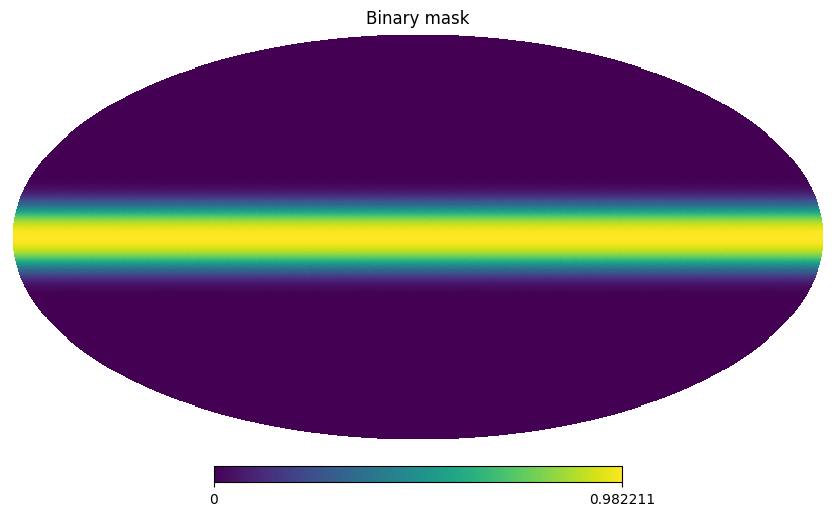

In [93]:
hp.mollview(mask, title="Binary mask")

Decoupled power spectra $\hat{C_l^{ij}} = M_{ll'}^{-1} \tilde{C}_l^{ij}$

where $\tilde{C}_l^{ij}$ is the pseudo power spectrum aka the masked power spectrum

In [94]:
pcl =np.zeros((lmax+1, n_freqs, n_freqs))
cl_dec = np.zeros((lmax+1, n_freqs, n_freqs))
ells = np.arange(len(pcl))
print(ells.shape)


for nf in range(n_freqs):
    f_0 =nmt.NmtField(1-mask, [maps_pl[nf,:]]) #initializing field with mask using pymaster
    pcl[:, nf,nf] = nmt.compute_coupled_cell(f_0,f_0) #masked power spectrum
    b = nmt.NmtBin.from_nside_linear(nside, 1) #no binning scheme
    # Create a NaMaster workspace
    w = nmt.NmtWorkspace.from_fields(f_0, f_0, b)

    # Extract the mode-coupling matrix
    mcm = w.get_coupling_matrix()
    mcm_inv= np.linalg.pinv(mcm) #taking the inverse of the mcm
    cl_dec[:, nf, nf] = np.einsum('ij,j->i', mcm_inv, pcl[:, nf, nf]) # decoupled power spectrum
print(mcm.shape)
print(mcm_inv.shape)
print(cl_dec.shape)

(384,)
(384, 384)
(384, 384)
(384, 7, 7)


Mode Coupling Matrix

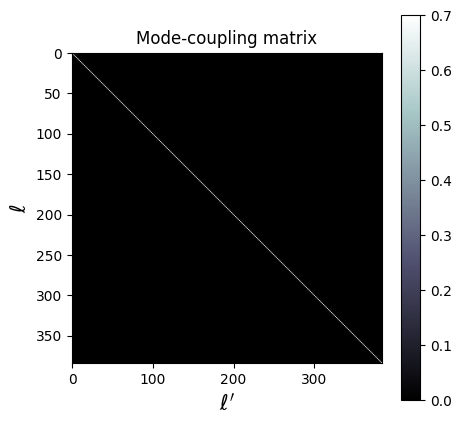

In [95]:
# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
#plt.plot(mcm[40,:])
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()
plt.show()

Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

(7, 7)
(7, 7)
(7,)
()
(7, 384)


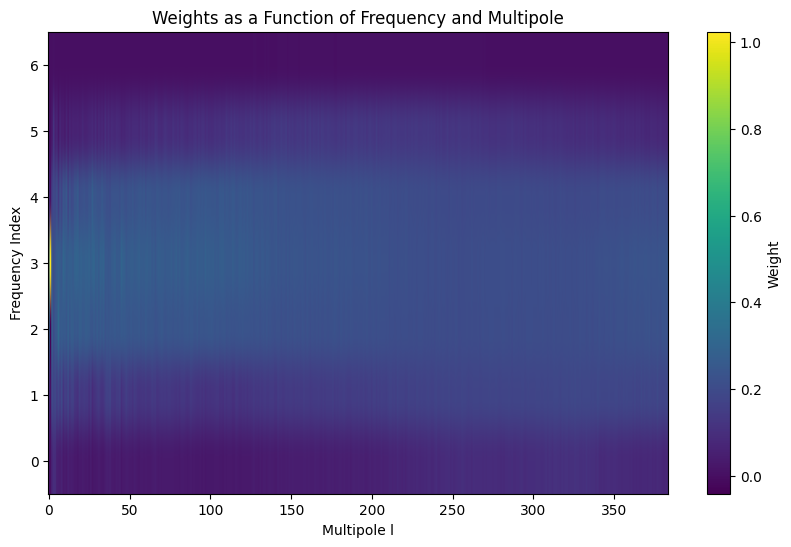

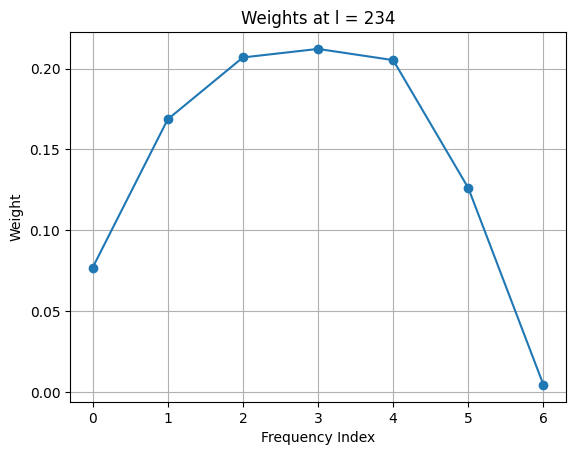

In [96]:
#CMB spectral energy density
b_j= np.ones(n_freqs, dtype=float ) #array filled with values of 1. column vector

w_i= np.zeros((n_freqs, lmax+1), dtype=float) #weights

cl_dec_inv =np.zeros((n_freqs, n_freqs), dtype=float)

for l in range(lmax+1):

    Cl_matrix =  cl_dec[l,:,:] #cov matrix for a specific l (nfreqs x nfreqs)
    

    cl_dec_inv[:,:] = np.linalg.pinv(Cl_matrix[:,:]) #(nfreqs x nfreqs)
    numerator = np.dot(cl_dec_inv,  b_j) #nfreqs x 1
    b_trans = b_j.T
    denominator = np.dot(b_trans, np.dot(cl_dec_inv, b_j)) #scalar?? 1x1
  

    for nf in range(n_freqs):
        w_i[:, l] = numerator[:]/denominator# (nfreqs x m) Since this is inside l loop it is only the weight for a specific l. looping will give us the correct shape?
print(Cl_matrix.shape)
print(cl_dec_inv.shape)
print(numerator.shape)
print(denominator.shape)
print(w_i.shape) #nf x m array
plt.figure(figsize=(10, 6))
plt.imshow(w_i, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="Weight")
plt.xlabel("Multipole l")
plt.ylabel("Frequency Index")
plt.title("Weights as a Function of Frequency and Multipole")
plt.show()


plt.plot(range(n_freqs), w_i[:, 234], marker='o', linestyle='-')

plt.xlabel("Frequency Index")
plt.ylabel("Weight")
plt.title(f"Weights at l = {234}")
plt.grid()
plt.show()

Masking the combined maps

In [97]:
masked =np.zeros((n_freqs, npix))
alm_masked= np.zeros((n_freqs, almsize), dtype=complex)

for nf in range(n_freqs):
    masked[nf,:] =maps_pl[nf,:] - maps_pl[nf,:]*(mask)
    alm_masked[nf,:] = hp.map2alm(masked[nf,:], lmax=lmax, mmax=None, iter=0, pol=False)


Sum over frequencies to get $a_{ILC}$ for every l weighted sum across all frequencies for each m to get a cleaned spherical harmonic coefficient alm for each m at a given l.

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [98]:
alm_ilc = np.zeros((almsize), dtype=complex)

for l in range(lmax +1):
    index= np.zeros((l+1), dtype=int)
    for m in range(l+1):
        index[m]= hp.Alm.getidx(lmax, l, m)
    alm_p = alm_masked[:, index]

    alm = np.dot(w_i[:,l], alm_p[:,:]) # multiplying (9x384) and (9x1) to get (384x1)=this is for one l (m =0-> l). we iterate over all l
    '''
    #summing over frequencies. and taking ALL m values for a fixed l. Looping over l means 
    so we get an alm weighted by contributions from all frequencies over all scales.
    this should be the same as writing alm_p??
    '''
    alm_ilc[index]= alm #putting alm values back into an array corresponding to their proper positions. flat array
    
print(alm.shape)
print(alm_ilc.shape)

(384,)
(73920,)


In [99]:
norm= (ells*(ells+1))/(2*np.pi)

Cl_cmb = hp.anafast(cmb_pl[0]) #input cmb map
f_cmb =nmt.NmtField(1-mask, [cmb_pl[0]])
pcl_cmb = nmt.compute_coupled_cell(f_cmb, f_cmb)
w_cmb = nmt.NmtWorkspace.from_fields(f_cmb, f_cmb, b)
mcm_cmb = w_cmb.get_coupling_matrix()
mcm_cmb_inv = np.linalg.pinv(mcm_cmb)
cmb_dec = np.dot(mcm_cmb_inv, pcl_cmb[0]) #decoupled cmb map

Converting back to pixel space

(196608,)


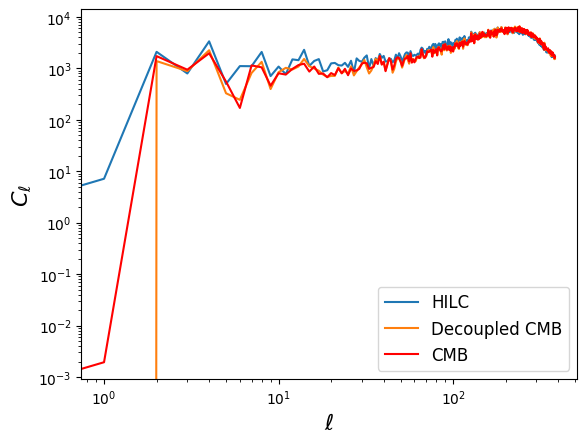

In [100]:
maps_out = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
print(maps_out.shape)

hilc =hp.anafast(maps_out)

#plt.plot(ells, (norm*cl_dec[:,4,4]/mean), label='Decoupled Cl')
plt.plot(ells, (norm*hilc), label='HILC')
plt.plot(ells, norm*cmb_dec, label='Decoupled CMB')
plt.plot(ells, norm*Cl_cmb, 'r-',label= 'CMB')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.show()

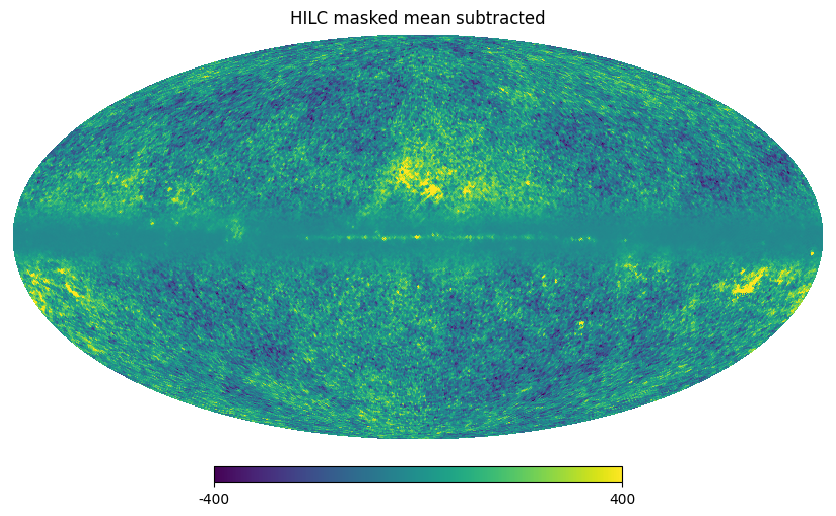

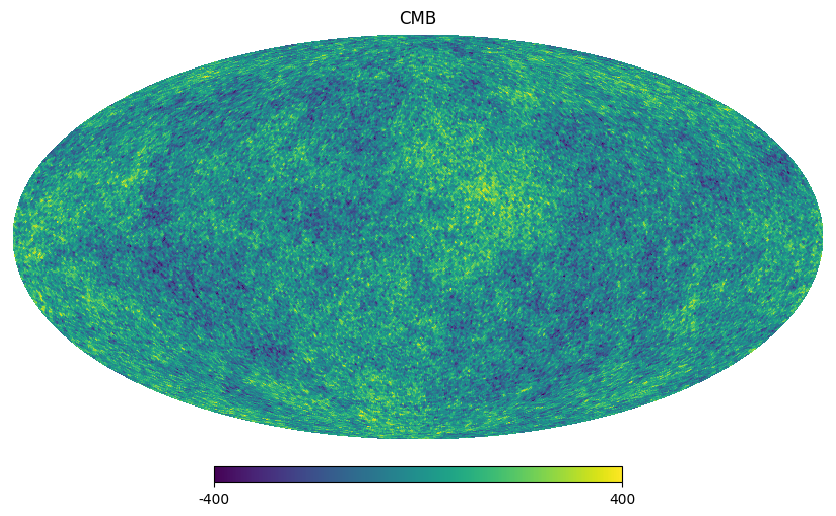

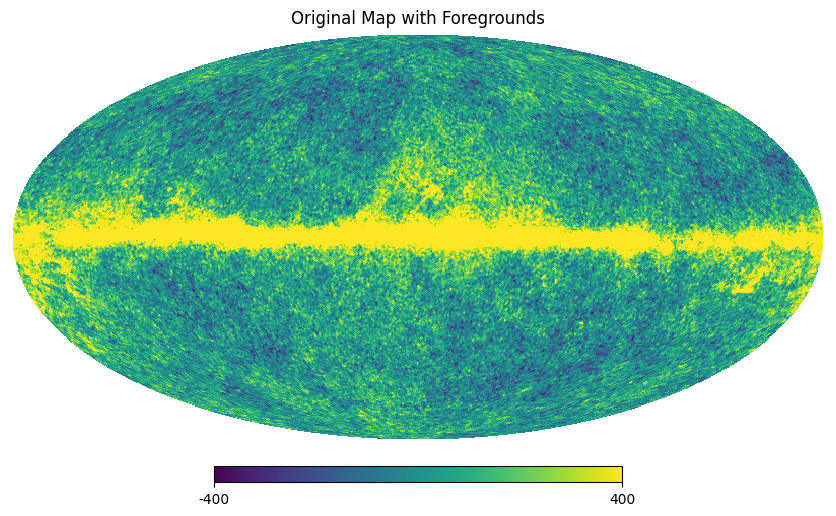

In [101]:
ilc =maps_out-np.mean(maps_out)
#hp.mollview(maps_out, title= "HILC masked", min=-400, max=400)
hp.mollview(ilc, title= "HILC masked mean subtracted", min=-400, max=400)
hp.mollview(cmb_pl[0],title ="CMB", min=-400, max=400)
hp.mollview(maps_pl[4], title="Original Map with Foregrounds", min=-400, max=400) #comparison to uncleaned
